In [1]:
import os
import rasterio

data_folder = "./prospace_assignment/prospace_assignment"

def calculate_average_shape(folder_path, batch_size=500):
    total_rows = 0
    total_cols = 0
    num_images = 0
    for idx, file_name in enumerate(os.listdir(folder_path), start=1):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            with rasterio.open(file_path) as src:
                total_rows += src.height
                total_cols += src.width
                num_images += 1
            if idx % batch_size == 0:
                average_rows = total_rows // num_images
                average_cols = total_cols // num_images
                print("Average shape after processing {} images: ({}, {})".format(idx, average_rows, average_cols))
   
    average_rows = total_rows // num_images
    average_cols = total_cols // num_images
    print("Final average shape of the raster images: ({}, {})".format(average_rows, average_cols))
    return (average_rows, average_cols)

average_shape = calculate_average_shape(data_folder)


Average shape after processing 500 images: (29, 30)
Average shape after processing 1000 images: (27, 29)
Average shape after processing 1500 images: (27, 29)
Average shape after processing 2000 images: (28, 31)
Average shape after processing 2500 images: (27, 31)
Average shape after processing 3000 images: (28, 32)
Average shape after processing 3500 images: (27, 31)
Average shape after processing 4000 images: (28, 32)
Average shape after processing 4500 images: (28, 32)
Average shape after processing 5000 images: (30, 34)
Average shape after processing 5500 images: (30, 35)
Average shape after processing 6000 images: (31, 35)
Average shape after processing 6500 images: (32, 36)
Final average shape of the raster images: (32, 36)


In [2]:
import os
import cv2
import csv
import numpy as np

data_folder = "./prospace_assignment/prospace_assignment"

def classify_image(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_lower = np.array([36, 25, 25])  
    green_upper = np.array([86, 255, 255])  
    brown_lower = np.array([10, 50, 20])  
    brown_upper = np.array([30, 255, 200])  
    white_lower = np.array([0, 0, 150])  
    white_upper = np.array([180, 25, 255]) 
    
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
    brown_mask = cv2.inRange(hsv_image, brown_lower, brown_upper)
    white_mask = cv2.inRange(hsv_image, white_lower, white_upper)
    
    green_pixels = cv2.countNonZero(green_mask)
    brown_pixels = cv2.countNonZero(brown_mask)
    white_pixels = cv2.countNonZero(white_mask)
    
    if green_pixels > brown_pixels and green_pixels > white_pixels:
        return 'lush'
    elif brown_pixels > green_pixels and brown_pixels > white_pixels:
        return 'growing'
    else:
        return 'no_crop'

annotations = []

def annotate_images(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)
            category = classify_image(image)
            annotations.append((file_path, category))

annotate_images(data_folder)

annotations_file = "annotations.csv"

with open(annotations_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['file_path', 'label'])  
    writer.writerows(annotations)

print("Annotations saved to:", annotations_file)


Annotations saved to: annotations.csv


In [3]:
import pandas as pd

annotations_file = "annotations.csv"

annotations_df = pd.read_csv(annotations_file)

print("Annotations DataFrame:")
print(annotations_df.head())

label_counts = annotations_df['label'].value_counts()

print("\nDistribution of Labels:")
print(label_counts)


Annotations DataFrame:
                                           file_path    label
0  ./prospace_assignment/prospace_assignment\100_...  growing
1  ./prospace_assignment/prospace_assignment\100_...  growing
2  ./prospace_assignment/prospace_assignment\100_...  growing
3  ./prospace_assignment/prospace_assignment\100_...  growing
4  ./prospace_assignment/prospace_assignment\100_...  growing

Distribution of Labels:
label
growing    5474
lush       1258
no_crop      84
Name: count, dtype: int64


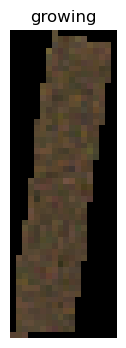

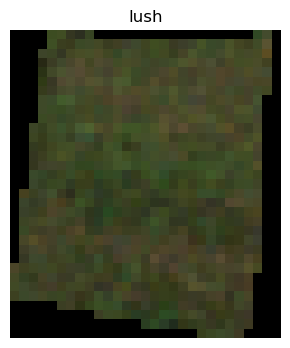

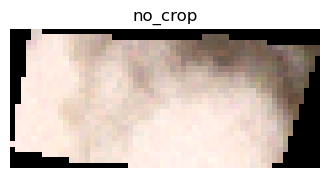

In [4]:
import matplotlib.pyplot as plt

def display_one_image_from_each_category(df):
    unique_labels = df['label'].unique()
    for label in unique_labels:
        image_path = df[df['label'] == label].iloc[3]['file_path']
        image = cv2.imread(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
        plt.show()

display_one_image_from_each_category(annotations_df)


In [5]:
from sklearn.model_selection import train_test_split
def preprocess_dataset(df, target_shape=(32, 36), test_size=0.2, random_state=42):
    # Resize and normalize images
    def preprocess_image(image_path):
        image = cv2.imread(image_path)
#         print("Data type of image:", type(image)) 
        image = cv2.resize(image, target_shape)
        image = image.astype(np.float32) / 255.0
        return image

    
    df['processed_image'] = df['file_path'].apply(preprocess_image)
    print("Data type of df['processed_image']:", df['processed_image'].dtype)  
    df['processed_image'] = df['processed_image'].apply(lambda x: x.reshape((*target_shape, 3)))  
    
    label_to_int = {'no_crop': 0, 'growing': 1, 'lush': 2}
    df['label'] = df['label'].map(label_to_int)
    
    
    X_train, X_test, y_train, y_test = train_test_split(df['processed_image'].values, df['label'], test_size=test_size, random_state=random_state)
    print("Data type of X_train:", type(X_train)) 
    print("Data type of y_train:", type(y_train))  
    
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)
    
    return np.array(X_train), np.array(X_test), y_train, y_test



X_train, X_test, y_train, y_test = preprocess_dataset(annotations_df)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Unique values in y_train:", np.unique(y_train))ss

print("Number of training samples per class:")
print(np.bincount(y_train))
print("Number of testing samples per class:")
print(np.bincount(y_test))


Data type of df['processed_image']: object
Data type of X_train: <class 'numpy.ndarray'>
Data type of y_train: <class 'pandas.core.series.Series'>
Shape of X_train: (5452,)
Shape of X_test: (1364,)
Unique values in y_train: [0 1 2]
Number of training samples per class:
[  65 4352 1035]
Number of testing samples per class:
[  19 1122  223]


In [6]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))
cnn_model = create_cnn_model(input_shape, num_classes)

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test))

test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

cnn_model.save("crop_growth_stage_model.h5")

NameError: name 'models' is not defined